<a href="https://colab.research.google.com/github/unicamp-dl/IA025_2022S1/blob/main/ex06/Fernando_Fortes_Granado/Exerc%C3%ADcio_6_Fernando_Fortes_Granado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Treinamento de uma CNN no CIFAR 10

In [1]:
nome = "Fernando Fortes Granado"

print(f'Meu nome é {nome}')

Meu nome é Fernando Fortes Granado


Este exercicío consiste em implementar e treinar no CIFAR-10 vários blocos de uma Resnet seguido de uma camada linear de classificação.

## Importação das bibliotecas

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

## Fixando as seeds

In [3]:
random.seed(123)
np.random.seed(123)
torch.manual_seed(123)

## Dataset e dataloader

### Definição do tamanho do minibatch

In [4]:
batch_size = 50

## Download do CIFAR-10

In [5]:
!mkdir ./data

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Criação do dataloader

In [6]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [7]:
batch_size = 50

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))

x_train, y_train = next(iter(train_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("Valores mínimo e máximo dos pixels: ", torch.min(x_train), torch.max(x_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 800
Número de minibatches de validação: 200
Número de minibatches de teste: 200

Dimensões dos dados de um minibatch: torch.Size([50, 3, 32, 32])
Valores mínimo e máximo dos pixels:  tensor(-1.) tensor(1.)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


## Implementando o Bloco Básico da Resnet

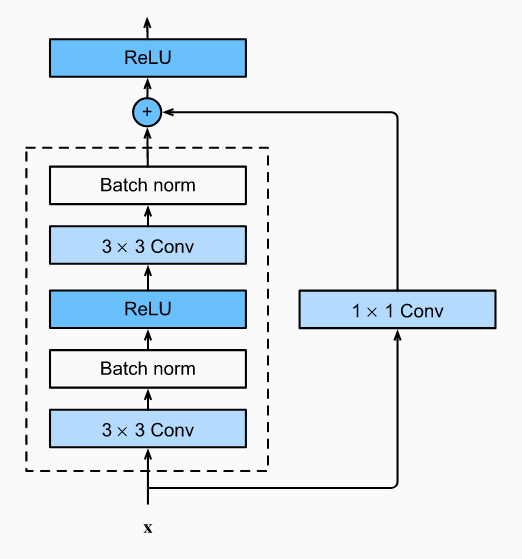

In [8]:
from torch import nn
from torch import Tensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class MyBasicBlock(nn.Module):

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
    ) -> None:
        super().__init__()
        # Escreva seu código aqui.
        self.downsample = nn.Conv2d(
            in_channels=inplanes, 
            out_channels=planes, 
            kernel_size=1, 
            stride=stride, 
            padding=0, 
            device=None,
            bias=False,
        )

        self.conv1 = nn.Conv2d(
            in_channels=inplanes, 
            out_channels=planes, 
            kernel_size=3, 
            stride=stride, 
            padding=1, 
            device=None,
            bias=False,
        )

        self.bn1 = nn.BatchNorm2d(num_features=planes, device=None)

        self.conv2 = nn.Conv2d(
            in_channels=planes, 
            out_channels=planes, 
            kernel_size=3, 
            stride=1, 
            padding="same", 
            device=None,
            bias=False,
        )

        self.bn2 = nn.BatchNorm2d(num_features=planes, device=None)

        self.relu = nn.ReLU()


    def forward(self, x: Tensor) -> Tensor:
        # Escreva seu código aqui.
        downsample = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + downsample
        out = self.relu(out)

        return out

## Compare se sua implementação está igual à do pytorch usando um exemplo aleatório

In [9]:
import torchvision

height_in = 5
width_in = 5
inplanes = 2
planes = 3
stride = 2

x = torch.rand(1, inplanes, height_in, width_in)

block = MyBasicBlock(inplanes=inplanes, planes=planes, stride=stride)

downsample = nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, padding=0, groups=1, bias=False, dilation=1)

block_pt = torchvision.models.resnet.BasicBlock(inplanes=inplanes, planes=planes, stride=stride, downsample=downsample)

# Usa os mesmos pesos para minha implementação e a do pytorch
block.load_state_dict(block_pt.state_dict())

out = block(x)
target_out = block_pt(x)

print(f'out:\n{out}')
print(f'target_out:\n{target_out}')

assert torch.allclose(out, target_out, atol=1e-6)

out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)
target_out:
tensor([[[[0.2084, 0.0000, 0.1053],
          [1.2176, 1.7145, 0.0000],
          [2.1509, 0.0000, 0.0000]],

         [[0.0000, 1.4478, 0.0000],
          [0.0000, 0.0000, 0.0000],
          [0.6579, 0.5231, 0.0000]],

         [[0.0000, 0.8983, 1.1205],
          [0.0000, 0.0000, 0.0225],
          [0.0000, 0.8017, 0.5681]]]], grad_fn=<ReluBackward0>)


## Modelo

Implemente um modelo de classificação que será treinado no CIFAR-10.

In [46]:
class Net(torch.nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        # Escreva seu código aqui.
        self.conv = nn.Sequential(
             MyBasicBlock(inplanes=3, planes=32, stride=1),
             MyBasicBlock(inplanes=32, planes=32, stride=1),
             MyBasicBlock(inplanes=32, planes=64, stride=2),
             MyBasicBlock(inplanes=64, planes=64, stride=1),
             MyBasicBlock(inplanes=64, planes=128, stride=2),
        )
        self.linear = nn.Linear(in_features=128, out_features=10)
         


    def forward(self, x):
        # Escreva seu código aqui.
        out = self.conv(x)
        out = out.mean([2, 3]) # global AVG pooling
        out = self.linear(out)

        return out

## Treinamento

### Definição dos hiperparâmetros

In [47]:
n_epochs = 20
lr = 0.01

### Detectando a GPU

In [48]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [49]:
def evaluation(model, loader):
    # Escreva seu código aqui.
    correct_guesses = 0
    num_samples = 0
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)
      outputs = model(x)
      pred = torch.argmax(outputs, axis=1)
      correct_guesses += torch.sum(pred == y)
      num_samples += y.shape[0]

    mean_accuracy = correct_guesses / num_samples
    print(f'Accuracy: {mean_accuracy}')

### Laço de treinamento

In [50]:
from tqdm import tqdm


model = Net()

model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr)

epochs = []
loss_history = []
loss_epoch_end = []
total_trained_samples = 0

# Primeira avaliação com pesos aleatórios
evaluation(model=model, loader=val_dataloader)

for i in range(n_epochs):
    model.train()
    for x_train, y_train in tqdm(train_dataloader, total=len(train_dataloader), desc='Training'):
        x_train = x_train.to(device)
        y_train = y_train.to(device)

        # predict da rede
        outputs = model(x_train)

        # calcula a perda
        loss = criterion(outputs, y_train)

        # zero, backpropagation, ajusta parâmetros pelo gradiente descendente
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_trained_samples += x_train.size(0)
        epochs.append(total_trained_samples / len(train_dataset))
        loss_history.append(loss.item())

    loss_epoch_end.append(loss.item())
    print(f'Epoch: {i:d}/{n_epochs - 1:d} Loss: {loss.item()}')

    # Chama a função de validação no final de cada época
    evaluation(model=model, loader=val_dataloader)

Accuracy: 0.10109999775886536


Training: 100%|██████████| 800/800 [00:20<00:00, 39.96it/s]


Epoch: 0/19 Loss: 1.3930119276046753
Accuracy: 0.4814999997615814


Training: 100%|██████████| 800/800 [00:25<00:00, 31.17it/s]


Epoch: 1/19 Loss: 1.3574784994125366
Accuracy: 0.5764999985694885


Training: 100%|██████████| 800/800 [00:20<00:00, 39.99it/s]


Epoch: 2/19 Loss: 0.873237133026123
Accuracy: 0.6316999793052673


Training: 100%|██████████| 800/800 [00:19<00:00, 40.46it/s]


Epoch: 3/19 Loss: 1.0297662019729614
Accuracy: 0.6712999939918518


Training: 100%|██████████| 800/800 [00:20<00:00, 38.58it/s]


Epoch: 4/19 Loss: 0.7903980016708374
Accuracy: 0.691100001335144


Training: 100%|██████████| 800/800 [00:19<00:00, 40.19it/s]


Epoch: 5/19 Loss: 0.5575293302536011
Accuracy: 0.7208999991416931


Training: 100%|██████████| 800/800 [00:21<00:00, 37.59it/s]


Epoch: 6/19 Loss: 0.7522155046463013
Accuracy: 0.7299999594688416


Training: 100%|██████████| 800/800 [00:19<00:00, 40.31it/s]


Epoch: 7/19 Loss: 0.5430195927619934
Accuracy: 0.7493999600410461


Training: 100%|██████████| 800/800 [00:20<00:00, 39.23it/s]


Epoch: 8/19 Loss: 0.7724546194076538
Accuracy: 0.7516999840736389


Training: 100%|██████████| 800/800 [00:20<00:00, 38.89it/s]


Epoch: 9/19 Loss: 0.47584986686706543
Accuracy: 0.7649999856948853


Training: 100%|██████████| 800/800 [00:19<00:00, 41.66it/s]


Epoch: 10/19 Loss: 0.3500318229198456
Accuracy: 0.765500009059906


Training: 100%|██████████| 800/800 [00:18<00:00, 42.19it/s]


Epoch: 11/19 Loss: 0.29964470863342285
Accuracy: 0.7590999603271484


Training: 100%|██████████| 800/800 [00:18<00:00, 42.80it/s]


Epoch: 12/19 Loss: 0.31227636337280273
Accuracy: 0.7766000032424927


Training: 100%|██████████| 800/800 [00:18<00:00, 42.84it/s]


Epoch: 13/19 Loss: 0.37222737073898315
Accuracy: 0.7825999855995178


Training: 100%|██████████| 800/800 [00:18<00:00, 42.41it/s]


Epoch: 14/19 Loss: 0.49325892329216003
Accuracy: 0.7764999866485596


Training: 100%|██████████| 800/800 [00:18<00:00, 42.41it/s]


Epoch: 15/19 Loss: 0.3289637863636017
Accuracy: 0.7699999809265137


Training: 100%|██████████| 800/800 [00:18<00:00, 42.62it/s]


Epoch: 16/19 Loss: 0.37604236602783203
Accuracy: 0.7843999862670898


Training: 100%|██████████| 800/800 [00:18<00:00, 42.39it/s]


Epoch: 17/19 Loss: 0.16777993738651276
Accuracy: 0.7886999845504761


Training: 100%|██████████| 800/800 [00:18<00:00, 42.55it/s]


Epoch: 18/19 Loss: 0.2667468190193176
Accuracy: 0.7851999998092651


Training: 100%|██████████| 800/800 [00:24<00:00, 33.13it/s]


Epoch: 19/19 Loss: 0.20865070819854736
Accuracy: 0.7798999547958374


### Visualização usual da perda, somente no final de cada minibatch

Text(0.5, 0, 'época')

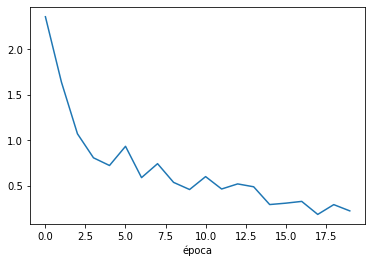

In [51]:
n_batches_train = len(train_dataloader)
plt.plot(epochs[::n_batches_train], loss_history[::n_batches_train])
plt.xlabel('época')

## Avaliação final no dataset de testes

In [52]:
evaluation(model=model, loader=test_dataloader)

Accuracy: 0.7822999954223633


# Bonus Opcional

## Implementando o Dropout

In [67]:
class MyDropout(torch.nn.Module):
    def __init__(self, p: float):
        # Escreva seu código aqui.
        self.p = p

    def forward(self, x: Tensor, training: bool):
        # Escreva seu código aqui.
        if training:
            mask = torch.rand(x.shape) > self.p
            return x * mask / (1 - p)
        return x

    def __call__(self, x, training:bool):  # definir o método __call__ foi inspirado pelo notebook de Leonardo Pacheco
      return self.forward(x, training)  

## Mostre que sua implementação traz resultados semelhantes à implementação do pytorch

In [68]:
import math

p = 0.5
dropout = MyDropout(p=p)

x = torch.rand(16, 3, 32, 32)

out = dropout(x, training=True)
out_pt = torch.nn.functional.dropout(x, p=p, training=True)

mean_zeros = (out == 0).sum() / out.numel()
mean_zeros_pt = (out_pt == 0).sum() / out_pt.numel()

print(f'mean zeros: {mean_zeros}')
print(f'mean zeros pytorch: {mean_zeros_pt}')

assert math.isclose(mean_zeros, mean_zeros_pt, abs_tol=1e-2)

out = dropout(x, training=False)
target_out = torch.nn.functional.dropout(x, p=p, training=False, inplace=False)
assert torch.allclose(out, target_out, atol=1e-6)

mean zeros: 0.498779296875
mean zeros pytorch: 0.5002238154411316
